<a href="https://colab.research.google.com/github/BielSousa/EstudosML/blob/main/RandomForestClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Telecom Churn
---
    Autor: Gabriel Farias
    Data: 28/08/2021
---
>**Churn** é uma métrica que indica o quanto sua empresa perdeu de
    receita ou clientes. Para calcular o churn, basta dividir a
    quantidade de clientes que perdeu até o final do período pelo
    total de clientes que iniciaram. 
>
>  **Exemplo: se você perdeu 10 clientes de 100 = 10% de churn rate.**
---

## OBJETIVO 
### Este estudo visa estimar o faturamento liquído da empresa através da estimativa de taxa de churn futura de uma empresa de telecom

---
BASES DE DADOS
* [churn-bigml-20.csv](https://github.com/BielSousa/EstudosML/blob/main/churn-bigml-20.csv )
* [churn-bigml-80.csv](https://github.com/BielSousa/EstudosML/blob/main/churn-bigml-80.csv)
---

In [ ]:
# Import das bibliotecas utlizadas no estudo
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Criando os dataframes
'''
    Seram duas bases serapadas uma com dados que iremos estudar "churn-bigml-80.csv" 
e ou quer iremos utilizar para simular o mundo real, onde não sabemos os novos dados.
Entretando já iremos deixar todos os dados em memória.
'''
df20 = pd.read_csv('/content/churn-bigml-20.csv')
df80 = pd.read_csv('/content/churn-bigml-80.csv')

### Exploração do Dataset

In [ ]:
df80.columns 

Index(['State', 'Account length', 'Area code', 'International plan',
       'Voice mail plan', 'Number vmail messages', 'Total day minutes',
       'Total day calls', 'Total day charge', 'Total eve minutes',
       'Total eve calls', 'Total eve charge', 'Total night minutes',
       'Total night calls', 'Total night charge', 'Total intl minutes',
       'Total intl calls', 'Total intl charge', 'Customer service calls',
       'Churn'],
      dtype='object')

In [ ]:
df80.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2666 entries, 0 to 2665
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   State                   2666 non-null   object 
 1   Account length          2666 non-null   int64  
 2   Area code               2666 non-null   int64  
 3   International plan      2666 non-null   object 
 4   Voice mail plan         2666 non-null   object 
 5   Number vmail messages   2666 non-null   int64  
 6   Total day minutes       2666 non-null   float64
 7   Total day calls         2666 non-null   int64  
 8   Total day charge        2666 non-null   float64
 9   Total eve minutes       2666 non-null   float64
 10  Total eve calls         2666 non-null   int64  
 11  Total eve charge        2666 non-null   float64
 12  Total night minutes     2666 non-null   float64
 13  Total night calls       2666 non-null   int64  
 14  Total night charge      2666 non-null   

        Podemos observar que não temos nenhum valor nulo.
        Sabemos que no mundo real a realidade seria diferente, entretanto
    para fins de estudo esta base de dados irá servir.
    

In [ ]:
df80.head(6)

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False
5,AL,118,510,Yes,No,0,223.4,98,37.98,220.6,101,18.75,203.9,118,9.18,6.3,6,1.70,0,False


In [ ]:
# Separando variaveis categoricas e numéricas
cats_columns = ['State','International plan','Voice mail plan']
nums_columns = ['Account length', 'Area code',  'Number vmail messages', 'Total day minutes',
       'Total day calls', 'Total day charge', 'Total eve minutes',
       'Total eve calls', 'Total eve charge', 'Total night minutes',
       'Total night calls', 'Total night charge', 'Total intl minutes',
       'Total intl calls', 'Total intl charge', 'Customer service calls','Churn']

In [ ]:
# Transformarção de variáveis categoricas [Internacional plan, Voice email plan e Churn] em discretas
df80['International plan'] = df80['International plan'].map(lambda x: 1 if x == 'Yes' else 0) 
df80['Voice mail plan'] = df80['Voice mail plan'].map(lambda x: 1 if x == 'Yes' else 0)
df80['Churn'] = df80['Churn'].map(lambda x: 1 if x else 0)
df20['International plan'] = df20['International plan'].map(lambda x: 1 if x == 'Yes' else 0) 
df20['Voice mail plan'] = df20['Voice mail plan'].map(lambda x: 1 if x == 'Yes' else 0)
df20['Churn'] = df20['Churn'].map(lambda x: 1 if x else 0)

In [ ]:
df80.head(6)

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0
1,OH,107,415,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
2,NJ,137,415,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0
3,OH,84,408,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0
4,OK,75,415,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0
5,AL,118,510,1,0,0,223.4,98,37.98,220.6,101,18.75,203.9,118,9.18,6.3,6,1.70,0,0


In [ ]:
# Verificando se há mais de um código de área por estado
df80.groupby(['State','Area code'])['State'].count()

State  Area code
AK     408           9
       415          21
       510          13
AL     408          22
       415          32
                    ..
WV     415          46
       510          27
WY     408          15
       415          35
       510          16
Name: State, Length: 153, dtype: int64

        Como há mais de um código de area por estado, transformaremos
    estado em variável discreta utilizando o LabelEncoder.
        O LabelEncoder, considera a ordem alfabetica na hora de fazer
    a transformação.

In [ ]:
# Primeiros 10 estados após a transformação
for num, state in enumerate(sorted(df80['State'].unique())):
    print(num+1,': ',state)
    if num == 9:
        break

1 :  AK
2 :  AL
3 :  AR
4 :  AZ
5 :  CA
6 :  CO
7 :  CT
8 :  DC
9 :  DE
10 :  FL


In [ ]:
label_encoder = LabelEncoder()
df80['State'] = label_encoder.fit_transform(df80['State'])
df80.head(5)

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,16,128,415,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0
1,35,107,415,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
2,31,137,415,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0
3,35,84,408,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0
4,36,75,415,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0


### Exploração das variáveis

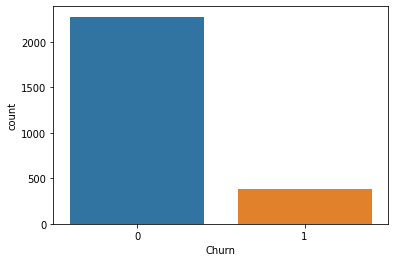

In [ ]:
sns.countplot(x=df80['Churn']);

        Varificamos que o target está desbalanceado, com isso o modelo
    aprende mais sobre o cliente que não fez Churn e menos sobre o clinte
    que não fez Churn. Isso leva ao a um erro maior de prever quem de fato
    irá fazer Churn.
    Quando isso ocorre temos 3 maneiras de lidar com essa situação:
        - Oversampling
        - Undersampling
        - Engenharia de atributos
    
    OVERSAMPLING
        É quando geramos novos dados a partir da classe com menos dados
        para igualar com a classe com maior quantidade.
    
    UNDERSAMPLING
        É quando reduzimos a classe com maior quantidade de dados para 
        igualar a classe com menor quantidade.
    
    ENGENHARIA DE ATRIBUTOS
        É gerar novos atributos para compensar o desbalanceamento.
        Entretanto esse método é muito custoso.

        Nesse estudo iremos abordar Oversampling e Undersampling 
    verificando quem tem  maior desempenho, entretanto antes 
    executaremos um modelo de machine learning nos dados desbalanceados
    para ver o resultado. 

In [ ]:
df80.describe()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
count,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.00000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000
mean,26.036009,100.620405,437.438860,0.101275,0.274944,8.021755,179.48162,100.310203,30.512404,200.386159,100.023631,17.033072,201.168942,100.106152,9.052689,10.237022,4.467367,2.764490,1.562641,0.145536
std,14.921792,39.563974,42.521018,0.301750,0.446570,13.612277,54.21035,19.988162,9.215733,50.951515,20.161445,4.330864,50.780323,19.418459,2.285120,2.788349,2.456195,0.752812,1.311236,0.352707
min,0.000000,1.000000,408.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,43.700000,33.000000,1.970000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,13.000000,73.000000,408.000000,0.000000,0.000000,0.000000,143.40000,87.000000,24.380000,165.300000,87.000000,14.050000,166.925000,87.000000,7.512500,8.500000,3.000000,2.300000,1.000000,0.000000
50%,26.000000,100.000000,415.000000,0.000000,0.000000,0.000000,179.95000,101.000000,30.590000,200.900000,100.000000,17.080000,201.150000,100.000000,9.050000,10.200000,4.000000,2.750000,1.000000,0.000000
75%,39.000000,127.000000,510.000000,0.000000,1.000000,19.000000,215.90000,114.000000,36.700000,235.100000,114.000000,19.980000,236.475000,113.000000,10.640000,12.100000,6.000000,3.270000,2.000000,0.000000
max,50.000000,243.000000,510.000000,1.000000,1.000000,50.000000,350.80000,160.000000,59.640000,363.700000,170.000000,30.910000,395.000000,166.000000,17.770000,20.000000,20.000000,5.400000,9.000000,1.000000


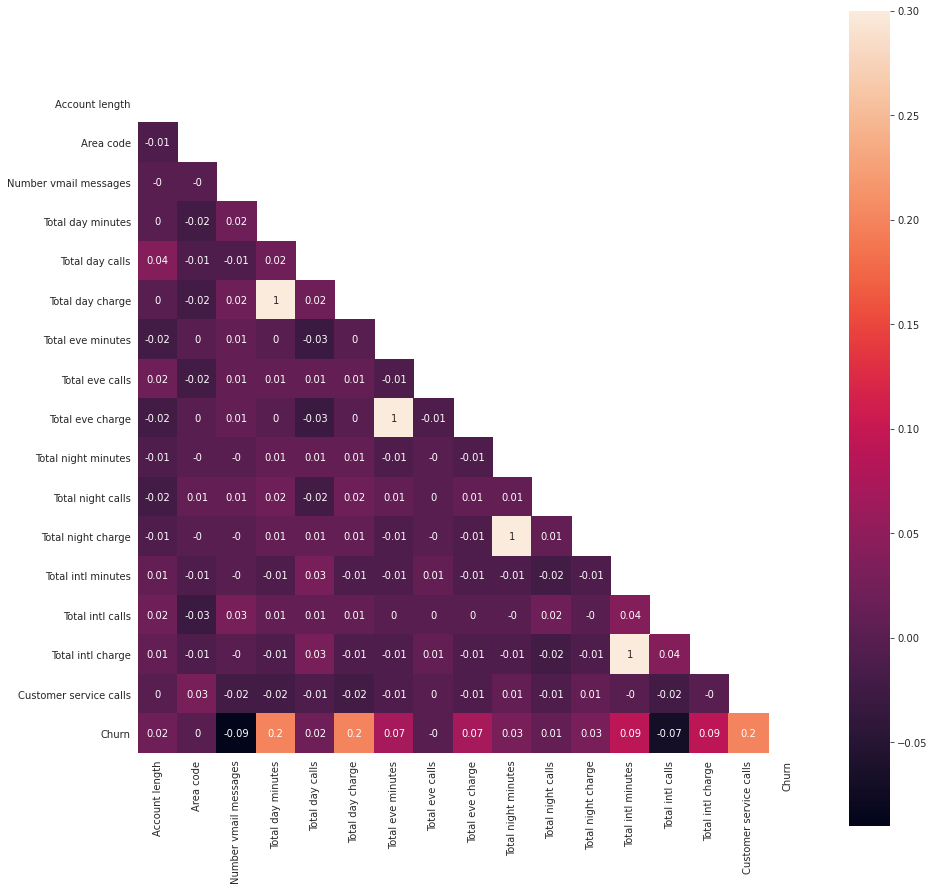

In [ ]:
# Verificação de correlação

corr = df80[nums_columns].corr().round(2)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(15, 15))
    ax = sns.heatmap(corr, mask=mask, vmax=.3, square=True,annot=True)

        Após essa verificação de correlação daremos um drop nas variáveis
    que tem uma baixa correlação com o Churn um total de 11 variáveis 
    restando apenas 8.
    
        Variaveis excluídas
        - State
        - Account Length
        - Area code
        - Voice mail plan
        - Numbers vmail messages
        - Total day calls
        - Total eve calls
        - Total night minutes 
        - Total night calls
        - Total night charge
        - Total intl calls

In [ ]:
df80.drop(columns=['State', 'Account length', 'Area code',
       'Voice mail plan', 'Number vmail messages',
       'Total day calls', 
       'Total eve calls',  'Total night minutes',
       'Total night calls', 'Total night charge',
       'Total intl calls'], inplace=True)

#fazendo o drop no df20 também
df20.drop(columns=['State', 'Account length', 'Area code',
       'Voice mail plan', 'Number vmail messages',
       'Total day calls', 
       'Total eve calls',  'Total night minutes',
       'Total night calls', 'Total night charge',
       'Total intl calls'], inplace=True)

In [ ]:
df80.head(5)

,International plan,Total day minutes,Total day charge,Total eve minutes,Total eve charge,Total intl minutes,Total intl charge,Customer service calls,Churn
0,0,265.1,45.07,197.4,16.78,10.0,2.70,1,0
1,0,161.6,27.47,195.5,16.62,13.7,3.70,1,0
2,0,243.4,41.38,121.2,10.30,12.2,3.29,0,0
3,1,299.4,50.90,61.9,5.26,6.6,1.78,2,0
4,1,166.7,28.34,148.3,12.61,10.1,2.73,3,0


# Aplicação de modelo de machine learnig com classes desbalanceadas

In [ ]:
x_train, x_test, y_train, y_test = df80.drop(columns='Churn'),df20.drop(columns='Churn'),df80['Churn'],df20['Churn']

In [ ]:
mod1 = RandomForestClassifier(random_state=0)
mod1.fit(x_train,y_train)
p1 = mod1.predict(x_test)

In [ ]:
print(f'Acurácia: {mod1.score(x_test,y_test)*100:.2f} %')

Acurácia: 91.60 %


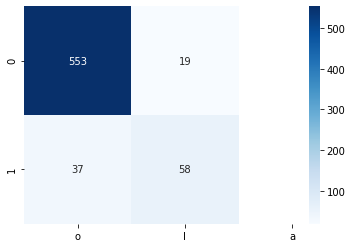

In [ ]:
sns.heatmap(confusion_matrix(y_test,p1, labels=mod1.classes_,),fmt='0', annot=True,cmap='Blues',);

In [ ]:
print(classification_report(y_test, p1))

              precision    recall  f1-score   support

           0       0.94      0.97      0.95       572
           1       0.75      0.61      0.67        95

    accuracy                           0.92       667
   macro avg       0.85      0.79      0.81       667
weighted avg       0.91      0.92      0.91       667



In [ ]:
print(f'taxa de churn prevista: {p1.sum()/len(p1)*100:.2f}%')

taxa de churn prevista: 11.54%


In [ ]:
# Limites Inferior e Superior em 10%
print(f'taxa de churn superior: {((p1.sum()+p1.sum()*0.1)/len(p1)*100):.2f}%')
print(f'taxa de churn inferior: {((p1.sum()-p1.sum()*0.1)/len(p1)*100):.2f}%')

taxa de churn superior: 12.70%
taxa de churn inferior: 10.39%


### Conclusão preliminar
        Através da aplicação do modelo conseguimos chegar em uma acurácia de 
    91% em prever se hávera churn do cliente ou não.
        Utilizando 10% de limites inferior e superior chegamos que nossa
    taxa de churn será entre 10.39% e 12.70%.
        
        Se supormos que cada cliente gere a receita R$ 100.00 para empresa 
    a cada 100 novos clientes, a empresa terá a certaza de um faturamento
    liquído de entre R$ 8730,00 e R$8961,00

    Entretanto essa conclusão pode estar equivocada.

## Aplicação do método Undersampling (NearMiss)

In [ ]:
# Aplicando o NearMiss
nr = NearMiss()
x_train_under, x_test_under, y_train_under, y_test_under = df80.drop(columns='Churn'),df20.drop(columns='Churn'),df80['Churn'],df20['Churn']
x_train_under, y_train_under = nr.fit_sample(x_train_under, y_train_under)

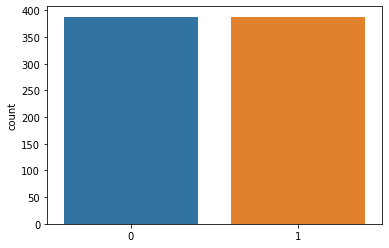

In [ ]:
# Verificando a quantidade de amostras de cada classe
sns.countplot(x=y_train_under);

In [ ]:
mod2 = RandomForestClassifier(random_state=0)
mod2.fit(x_train_under,y_train_under)
p2 = mod2.predict(x_test_under)

In [ ]:
print(f'Acurácia: {mod2.score(x_test_under,y_test_under)*100:.2f} %')

Acurácia: 60.27 %


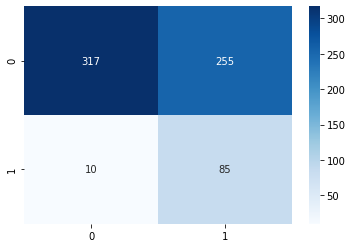

In [ ]:
sns.heatmap(confusion_matrix(y_test_under,p2, labels=mod2.classes_,),fmt='0', annot=True,cmap='Blues',);

In [ ]:
print(classification_report(y_test_under, p2))

              precision    recall  f1-score   support

           0       0.97      0.55      0.71       572
           1       0.25      0.89      0.39        95

    accuracy                           0.60       667
   macro avg       0.61      0.72      0.55       667
weighted avg       0.87      0.60      0.66       667



## Aplicação do Oversampling(SMOTE)

In [ ]:
# Aplicando o NearMiss
smote = SMOTE()
x_train_over, x_test_over, y_train_over, y_test_over = df80.drop(columns='Churn'),df20.drop(columns='Churn'),df80['Churn'],df20['Churn']
x_train_over, y_train_over = smote.fit_sample(x_train_over, y_train_over)

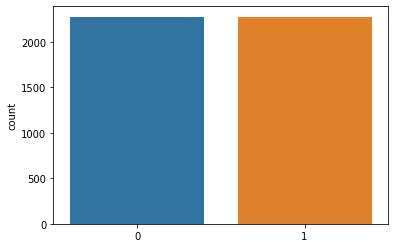

In [ ]:
# Verificando a quantidade de amostras de cada classe
sns.countplot(x=y_train_over);

In [ ]:
mod3 = RandomForestClassifier(random_state=0)
mod3.fit(x_train_over,y_train_over)
p3 = mod3.predict(x_test_over)

In [ ]:
print(f'Acurácia: {mod3.score(x_test_over,y_test_over)*100:.2f} %')

Acurácia: 91.00 %


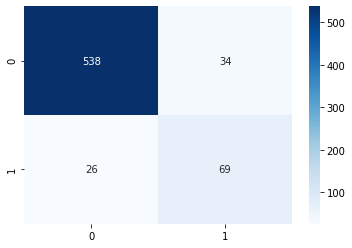

In [ ]:
sns.heatmap(confusion_matrix(y_test_over,p3, labels=mod3.classes_,),fmt='0', annot=True,cmap='Blues',);

In [ ]:
print(classification_report(y_test_over, p3))

              precision    recall  f1-score   support

           0       0.95      0.94      0.95       572
           1       0.67      0.73      0.70        95

    accuracy                           0.91       667
   macro avg       0.81      0.83      0.82       667
weighted avg       0.91      0.91      0.91       667



## Conclusão

        Como vimos os modelos desbalanceados e método Oversampling, tiveram 
    desempenhos parecidos. A partir daqui ficaria a cargo da equipe de négocios
    determinar qual situação deveriamos focar com a aplicação do modelo, pois
    dependendo da ocasião adimiti-se aumentar o erro do falso positivo
    (errar mais quem não vai churnar) para diminuir o acerto falso negativo
    (acertar quem vai churnar). 